<a href="https://colab.research.google.com/github/UOS-COMP6252/public/blob/main/lecture5/conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;">COMP6252 Deep Learning Technologies</h1>
<h2 style="text-align: center;"> Lecture 5</h2>
<h2 style="text-align: center;"> Convolution Networks</h2>

In [1]:
## We will be using comet_ml to log our experiments
import getpass
import os
try:
  import comet_ml
except ModuleNotFoundError:
  %pip install comet_ml
  import comet_ml
comet_api_key=os.environ.get("COMET_API_KEY")
if comet_api_key is None:
  comet_api_key=getpass.getpass("Enter key")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import SGD,Adam

## Convolution and Max pooling examples in PyTorch

Note the following:

1. The **depth** of every filter **must** be equal to the number of input channels
1. A filter has different values for each input channel
1. The convolution operation sums the contributions from all the channels
1. Therefore the number of output channels is exactly equal to the number of filters

In [4]:
# a and b have 2 channels each with dimension 3x3
a=torch.ones([2,3,3])
a[1,:,:]=3.
b=torch.ones([2,3,3])
# stack a and b together to create a sample of size (batch) 2
x=torch.stack([a,b])

print("X's size={}".format(list(x.size())))
print("a[0]=\n{}".format(a[0].numpy()))
print("a[1]=\n{}".format(a[1].numpy()))

X's size=[2, 2, 3, 3]
a[0]=
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
a[1]=
[[3. 3. 3.]
 [3. 3. 3.]
 [3. 3. 3.]]


Recall dimensions used in the convolution operation.
Let $s,i,j,f$ be the number of samples,output height index,output width index, and the filter index respectively. The convolution operation is defined as
\begin{align*}
O_{s,f,i,j}=b_f+ \sum_c\sum_{m,n}X_{s,c,i+m,j+n}*K_{f,c,m,n}
\end{align*}

- The ```c``` dimensions is fixed by the number of channels in the input.
- In the case of ```a```, ```b```, and by extension ```x```, the # of channels is 2
- In this example we choose 3 filters, each with height and width of 2x2
- In Pytorch a convolution layer is created as follows

```nn.Conv2d(in_channels=2,out_channels=3,kernel_size=2,bias=False)```
- Note that we chose to omit the bias for simplicity

In [6]:
# the in_channels must be 2 to match # channels (not the batch size) of a and b
l=nn.Conv2d(in_channels=2,out_channels=3,kernel_size=2,bias=False)
with torch.no_grad():
    # all values set to 1 except the second channel to 3 (for all filters)
    l.weight.fill_(1.)
    l.weight[:,1,:,:].fill_(3.)
p=l.parameters()
w=next(p)
s=w.size()
print("num filters={},channel={},height={},width={}".format(s[0],s[1],s[2],s[3]))

num filters=3,channel=2,height=2,width=2


In [10]:
d=l(x)
s=d.size()
print(s)
print("num of output samples={},channels={},height={},width={}".format(s[0],s[1],s[2],s[3]))
print(l(a).size())

torch.Size([2, 3, 2, 2])
num of output samples=2,channels=3,height=2,width=2
torch.Size([3, 2, 2])


Consider the output for the first sample (the convolution of ```a```). Since all the kernels are the same we inspect one output channel. Therefore, we are considering the values in ```d[0,0,:,:]```.

```a``` has two input channels: the first has values all ones and the second all 3s.
The filter has values ones for the first channel and 3s for the second. Since the receptive field is 2x2 then the convolution would result in:
\begin{align*}
(1\times 1+1\times 1+1\times 1+1\times 1)+(3\times 3+3\times 3+3\times 3+3\times 3)\\
=40
\end{align*}

In [6]:
# convolution of a
print(d[0,0,:,:].detach().numpy())

[[40. 40.]
 [40. 40.]]


The output of the second sample (the convolution of ```b```) is similar
\begin{align*}
(1\times 1+1\times 1+1\times 1+1\times 1)+(1\times 3+1\times 3+1\times 3+1\times 3)\\
=16
\end{align*}

In [7]:
# convolution of b
print(d[1,0,:,:].detach().numpy())

[[16. 16.]
 [16. 16.]]


### Max pooling

- Recall that max pooling with kernel size $h\times w$ and stride $s$ computes the maximum value of the input in the window $h\times w$.
- It then "slides" that window by $s$.
- Max pooling is performed in PyTorch using ```nn.MaxPool2d```
- Example:
- Input is a single channel with size 3x3
- By default the kernel is square so specifying 2 means 2x2
- By default the stride is the same as the kernel size


In [8]:
a=torch.tensor([[1,2,3],[4,5,6],[7,8,9]],dtype=torch.float32)
b=torch.tensor([[10,11,12],[13,14,15],[16,17,18]],dtype=torch.float32)
# stack a and b together to create a sample of size 2
x=torch.stack([a,b])

# By default a square kernel so 2 is the same as 2x2
# If the stride is not specified it defaults to kernel size
maxpool=nn.MaxPool2d(2)
y=maxpool(x)
print(y.numpy())

[[[ 5.]]

 [[14.]]]


- Notice how the above has a single value. 
- Because when a stride of 2 (the default) is applied, the kernel "overshoots" the input 
- Figure below represents the computation for "sample" ```a```
- Therefore only a single computation is done

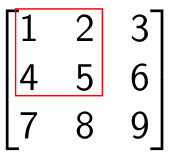

- What if we changed the stride to 1?
- The obtained values are easy to interpret with the help of the image above

In [9]:
maxpool=nn.MaxPool2d(kernel_size=2,stride=1)
y=maxpool(x)
print(y)

tensor([[[ 5.,  6.],
         [ 8.,  9.]],

        [[14., 15.],
         [17., 18.]]])


### Convolution Network for CIFAR10

In [10]:
# to ensure some reproducibility 
torch.manual_seed(9)

In [11]:
batch_size=64
transform = transforms.ToTensor()
dataset_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=transform)
dataset_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=transform)
loader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=2)
loader_test=DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # input is (*,3,32,32)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
    self.relu=nn.ReLU()
    # input is (*,32,30,30)
    self.pool1=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,32,15,15)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    # input is (*,64,13,13)
    self.pool2=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,6,6)
    self.conv3=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    # input is (*,64,4,4)
    self.pool3=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,2,2)
    self.flatten=nn.Flatten()
    # input is (*,64x2x2)
    self.fc1=nn.Linear(in_features=2*2*64,out_features=64)
    self.fc2=nn.Linear(in_features=64,out_features=10)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.pool1(x)

    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool2(x)
    
    x=self.conv3(x)
    x=self.relu(x)
    x=self.pool3(x)
    
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x
    

In [13]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.block=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
    def forward(self,x):
        return self.block(x)
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            Block(3,32),
            Block(32,64),
            Block(64,64),
            nn.Flatten(),
            nn.Linear(in_features=2*2*64,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=10)
        )
    
    def forward(self,x):
        
        return self.net(x)

In [14]:
def get_accuracy(dataloader,model):
  total=len(dataloader.dataset.data)
  correct=0
  for data in dataloader:
    imgs,labels=data
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
    _,predicted=torch.max(outputs.data,1)
    correct+=(predicted==labels).sum()
  

  return (correct/total).item()

In [15]:
lr=0.001
model=Net2().cuda()
# lr=0.001 is the default learning rate for Adam
# we specify it explicitly here for clarity
# and because we want to log it in comet
optimizer=Adam(model.parameters(),lr=lr)
loss_fn=nn.CrossEntropyLoss()

In [16]:
experiment = comet_ml.Experiment(api_key=comet_api_key,workspace="COMP6252",project_name="Convnet",auto_metric_logging=False, auto_output_logging=False)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/comp6252/convnet/fb8838f9018f44af994347d4ba40d426



In [17]:

epochs=50
experiment.log_parameters({'lr':lr,'batch_size':batch_size,'epochs':epochs})
from tqdm import tqdm
for epoch in range(epochs):
  loop=tqdm(loader_train)
  loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
  epoch_loss=0.
  for (imgs,labels) in loop:
    optimizer.zero_grad()
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss=0.9*epoch_loss+0.1*loss.item()
    loop.set_postfix(loss=epoch_loss)
   
  acc=get_accuracy(loader_test,model)
  experiment.log_metrics({'loss':epoch_loss,'val_accuracy':acc}, epoch=epoch)
  

Epoch [50/50]: 100%|██████████| 782/782 [00:03<00:00, 214.80it/s, loss=0.285]


In [18]:
try:
    from torchmetrics import ConfusionMatrix
except ModuleNotFoundError:
    !pip install torchmetrics
    from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(task='multiclass',num_classes=10)
conmat=conmat.cuda()

In [19]:
total=0
correct=0
for data in loader_test:
  imgs,labels=data
  imgs=imgs.cuda()
  labels=labels.cuda()
  outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
  _,predicted=torch.max(outputs.data,1)
  correct+=(predicted==labels).sum()
  total+=labels.size()[0]
  conmat.update(predicted,labels)
test_accuracy=(correct/total).item()
print(f"Accuracy={test_accuracy:0.3f}")
experiment.log_metrics({"test_accuracy":test_accuracy})

Accuracy=0.686


<Axes: >

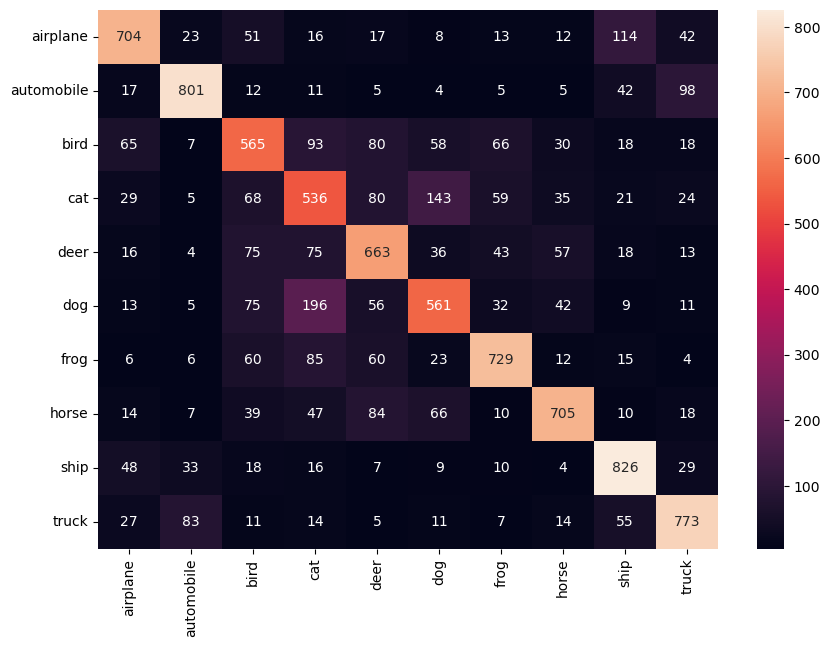

In [20]:
import matplotlib.pyplot as plt
import seaborn as sb
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")

- The rows are the actual images and the columns are the prediction (How can you check?)
- While the prediction accuracy is good albeit not impressive
- From the confusion matrix we find justifications for the inaccuracies
- For example
    - most of the incorrect classifications of automobiles were classified as trucks
    - most of the incorrect classifications of cats/dogs were classified as dogs/cats
    

In [21]:
experiment.log_confusion_matrix(matrix=x,labels=dataset_train.classes)
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/comp6252/convnet/fb8838f9018f44af994347d4ba40d426
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [50]         : (0.25983746466305746, 1.4500389557868023)
COMET INFO:     test_accuracy     : 0.6862999796867371
COMET INFO:     val_accuracy [50] : (0.47110000252723694, 0.7112999558448792)
COMET INFO:   Parameters:
COMET INFO:     batch_size : 64
COMET INFO:     epochs     : 50
COMET INFO:     lr         : 0.001
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     confusion-matrix      